In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from table_reader import TableReader
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LogisticRegression

Hey folks, I'm just trying out a proof-of-concept jupyter notebook that uses our data retrieval code.

I got sick of working with environment variables so I switched to a new method to store our DB password:
    1. Create a file called config.json in the project root.
    2. Inside, config.json should look like this:
    {
        "database_url":"database_url_goes_here"
    }

TableReader's other vector methods are geodata_vector() and reviews_vector(). Be sure to call close() when you're done so it terminates the connection to the DB.

In [36]:
tr = TableReader()
prop = tr.properties_vector(include_amenitites=True)
geo = tr.geodata_vector()
tr.close()


In [50]:
df = pd.merge(geo,
            prop,
            on='listingID')

In [51]:
df.head()

,listingID,zipcode,latitude,longitude,"Brightwood Park, Crestwood, Petworth","Brookland, Brentwood, Langdon","Capitol Hill, Lincoln Park","Capitol View, Marshall Heights, Benning Heights","Cathedral Heights, McLean Gardens, Glover Park","Cleveland Park, Woodley Park, Massachusetts Avenue Heights, Woodland-Normanstone Terrace",...,Extra pillows and blankets,translation missing: en.hosting_amenity_50,Cat(s),Dryer,Internet,Iron,Family/kid friendly,First aid kit,Keypad,Suitable for events
0,124030,20001.0,38.91409,-77.02484,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
1,3344,20005.0,38.90126,-77.02857,0,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,1
2,3662,20020.0,38.86193,-76.98963,0,0,0,0,0,0,...,0,0,0,1,1,0,1,1,0,1
3,3686,20020.0,38.86314,-76.98836,0,0,0,0,0,0,...,1,0,0,1,1,0,1,1,0,0
4,3771,20009.0,38.92760,-77.03926,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [74]:
features = df[df.columns.drop(['price', 'listingID'])]
label = df['price']

In [75]:
model = ElasticNet()
esfm = SelectFromModel(model)
esfm.fit(features, label)
print(list(features.iloc[:, esfm.get_support(indices=True)]))

['Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street', 'Dupont Circle, Connecticut Avenue/K Street', 'accomodates', 'bathrooms', 'bedrooms', 'Serviced apartment', 'Entire home/apt', 'Private room', 'Shared room', 'Fire extinguisher', 'Self check-in', 'Cable TV', 'Free parking on premises', 'Washer', 'TV', 'Pool', 'Lock on bedroom door', 'Free street parking', 'Gym', 'Indoor fireplace', 'Elevator', 'Dryer', 'Internet', 'Family/kid friendly', 'First aid kit']


In [76]:
model = Lasso()
sfm = SelectFromModel(model)
sfm.fit(features, label)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['zipcode', 'Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street', 'Dupont Circle, Connecticut Avenue/K Street', 'accomodates', 'bathrooms', 'bedrooms', 'Serviced apartment', 'Entire home/apt', 'Shared room', 'Self check-in', 'Cable TV', 'Free parking on premises', 'TV', 'Lock on bedroom door', 'Free street parking', 'Gym', 'Indoor fireplace', 'Elevator', 'Dryer', 'Internet', 'Family/kid friendly', 'First aid kit']


In [77]:
model = Ridge()
sfm = SelectFromModel(model)
sfm.fit(features, label)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['latitude', 'longitude', 'Capitol Hill, Lincoln Park', 'Cleveland Park, Woodley Park, Massachusetts Avenue Heights, Woodland-Normanstone Terrace', 'Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street', 'Dupont Circle, Connecticut Avenue/K Street', 'Edgewood, Bloomingdale, Truxton Circle, Eckington', 'Georgetown, Burleith/Hillandale', 'Howard University, Le Droit Park, Cardozo/Shaw', 'Kalorama Heights, Adams Morgan, Lanier Heights', 'Near Southeast, Navy Yard', 'Shaw, Logan Circle', 'Southwest Employment Area, Southwest/Waterfront, Fort McNair, Buzzard Point', 'Spring Valley, Palisades, Wesley Heights, Foxhall Crescent, Foxhall Village, Georgetown Reservoir', 'Union Station, Stanton Park, Kingman Park', 'West End, Foggy Bottom, GWU', 'bathrooms', 'bedrooms', 'Apartment', 'Condominium', 'Guest suite', 'House', 'Serviced apartment', 'Entire home/apt', 'Shared room', 'Bathtub', 'Hot tub', 'Extra pillows and blankets']


In [78]:
elastic_data = df[list(features.iloc[:, esfm.get_support(indices=True)])]

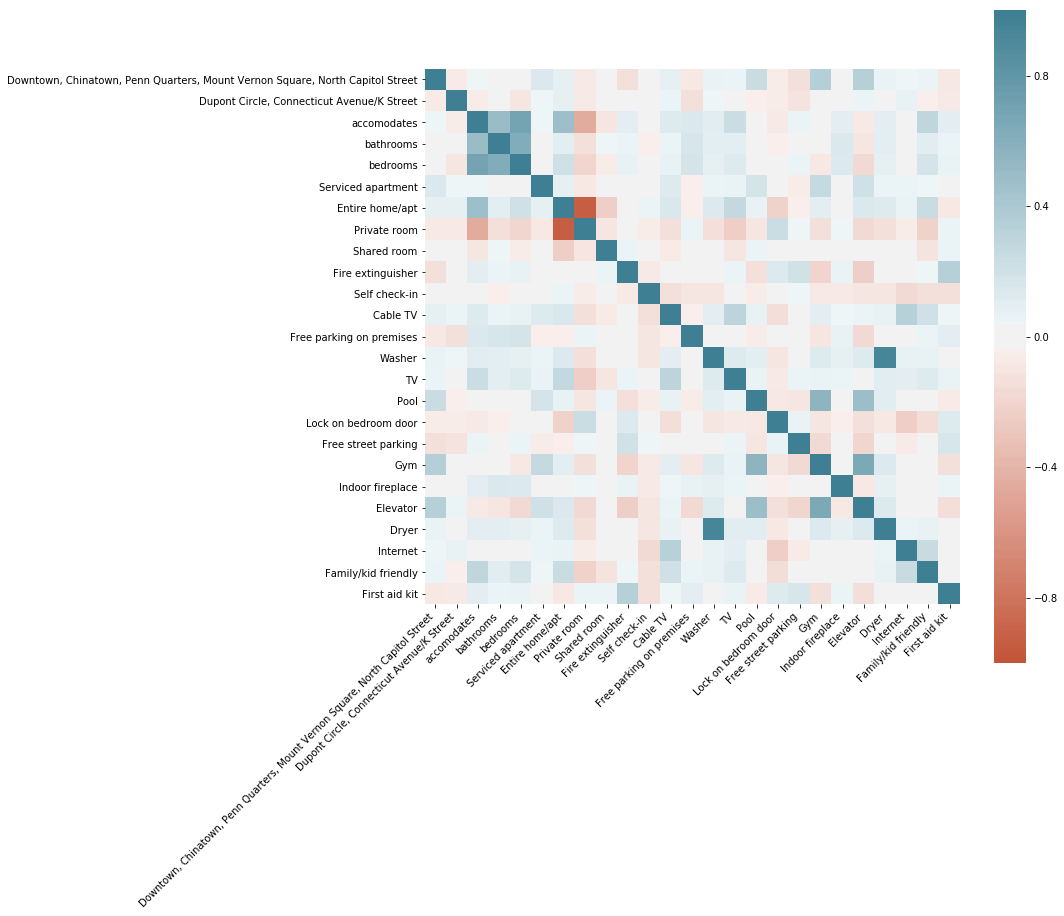

In [79]:
corr = elastic_data.corr()
plt.figure(figsize=(12, 12))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [80]:
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

X_train, X_test, y_train, y_test = tts(features, label, test_size=0.2)


In [81]:
regr = LinearRegression()
regr.fit(X_train,y_train)
print(mean_squared_error(y_test, regr.predict(X_test)))
print(regr.score(X_test,y_test))

2674.5338509360527
0.5342979147961171


In [82]:
import numpy as np

# try 200 different alphas between -10 and -2
n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)

model_ridge = RidgeCV(alphas=alphas)
model_ridge.fit(X_train, y_train)

#which alpha did it pick?
print(model_ridge.alpha_)


0.01


In [83]:
ridge = Ridge(alpha=0.01)
model_ridge.fit(X_train, y_train)
print(mean_squared_error(y_test, model_ridge.predict(X_test)))
print(model_ridge.score(X_test, y_test))

2674.6452000920767
0.5342785261710197


In [84]:
lasso = Lasso(alpha=0.5)
lasso.fit(X_train, y_train)
print(mean_squared_error(y_test, lasso.predict(X_test)))
lasso.score(X_test, y_test)

2937.654270176925


0.4884821821377669